### Import libraries

In [50]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Read .csv

In [6]:
os.listdir()

['rick_diamonds.csv',
 'diamonds.csv',
 'README.md',
 '.gitignore',
 '.gitattributes',
 '.ipynb_checkpoints',
 '.git',
 'diamond_project.ipynb']

In [4]:
data = pd.read_csv('diamonds.csv')

In [7]:
rick = pd.read_csv('rick_diamonds.csv')

#### Save backup files

In [9]:
data_bk = data.copy()

In [10]:
rick_bk = rick.copy()

### Understand database

In [11]:
data.describe()

,carat,depth,table,price,x,y,z
count,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000
mean,0.797817,61.751931,57.451161,3934.409644,5.730712,5.734333,3.538648
std,0.474126,1.430026,2.233450,3989.333861,1.121920,1.145344,0.706817
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


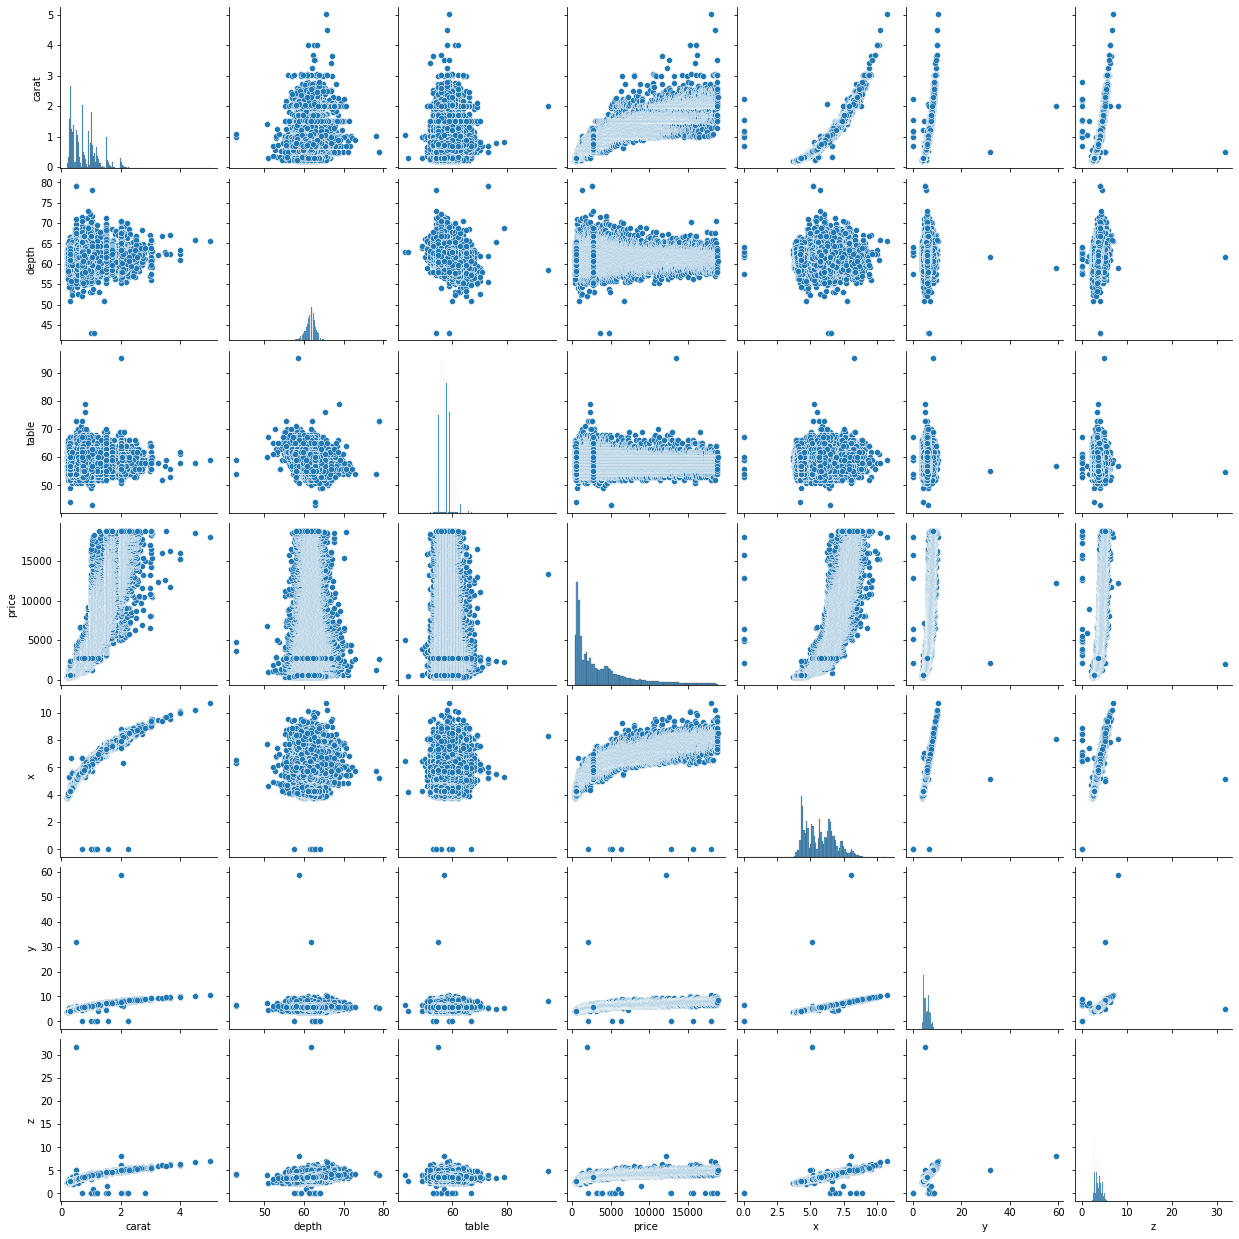

In [29]:
sns.pairplot(data);

In [36]:
data.corr()['price']

carat    0.922186
depth   -0.012037
table    0.127832
price    1.000000
x        0.885019
y        0.864059
z        0.860247
Name: price, dtype: float64

### Build model

#### Creating model using 'carat' given its correlation with price

In [45]:
model = LinearRegression()
X = data[['carat']]
y = data['price']

#### Training model with historical data

In [46]:
model.fit(X,y)

LinearRegression()

#### Predicting new prices with model

In [47]:
y_pred = model.predict(X) 

In [51]:
mean_squared_error(y, y_pred)

2380375.235074832